<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/SeHyunTx_ray_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## ModuleNotFoundError: No module named 'layers'


#! pip install layers:해결 불가

#! pip3 install --upgrade pip
#! pip3 install --upgrade tensorflow

#!pip install --upgrade layers
#해결: 파일 디렉토리 path수정

In [ ]:
#ModuleNotFoundError: No module named 'flair'

!pip install flair

위와 같은 에러들이 뜬 이유는 결국 custom libaries를 불러오지 않았기 때문에 이때, clone를 해야 편하다는 사실을 잊지 말자 그렇지 않으면 삽질이다.

### Importing Libraries

In [ ]:
import os
import sys
import pickle
from collections import Counter, OrderedDict

import pandas as pd

import torch

import plotly
import plotly.express as px
import plotly.graph_objects as go

# Custom libraries
sys.path.append('Objectives/')
from layers import LSTMLM, LSTMClassifier, LSTMPoolingClassifier
from collect_data_ import DataAggregrator
from preprocess import DataPreprocessor
from load_data import Corpus
from utilities import sent_2_index

sys.path.append('Evaluation_metrics/')
from measures import calculate_hellinger_distance

sys.path.append('Visualize/')
from plots import mass_activation_plot, freq_analysis_plot, hellinger_length_plot, length_shift_token_plot
from plots import length_shift_pos_plot, plot_least_10_hellinger_neurons, plot_top_10_hellinger_neurons

from prepare_data import convert_raw_data_into_csv

import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1" # see devices

#### 전역변수와 입력값

In [ ]:
imdb_label_to_idx = {"neg":0,"pos":1}
data_dict = {
    "models":{
    "pretrained_lm":{
        "model_type":"LSTM",
        "model_dir":"trained_models/LSTM/trained_lm.pt", # directory of the trained model
        "epoch_1_model_dir":"trained_models/LSTM/epoch_1_lm.pt",
        "epoch_48_model_dir":"trained_models/LSTM/epoch_48_lm.pt",
        "epoch_49_model_dir":"trained_models/LSTM/epoch_49_lm.pt",
        "model_class":LSTMLM, # class it belongs to in the module layer.
        "n_layers":1, # number of layers
        "emsize":100, # embedding size
        "nhid":100, # hidden units
        "batch_size":20, # batch size
        "seq_len":10, # sequence length/bptt
        "dropout":0.65, # recurrent dropout
        "saved_tsv_dir":"data/unsup_data.tsv", # directory of aggregrated data stored
        "fields_to_generate": ['inputs', 'outputs','activations', 'POS', 'max_activations', 'max_activation_index'],
        "layers_to_extract":[-1] # get activations from the last layer
    },
    "zero_shot":{
        "model_type":"LSTM",
        "model_dir":"trained_models/LSTM/trained_lm.pt", # directory of the trained model
        "model_class":LSTMLM, # class it belongs to in the module layer.
        "n_layers":1, # number of layers
        "emsize":100, # embedding size
        "nhid":100, # hidden units
        "batch_size":20, # batch size
        "seq_len":10, # sequence length/bptt
        "dropout":0.65, # recurrent dropout
        "saved_tsv_dir":"data/zero_shot_data.tsv", # directory of aggregrated data stored
        "fields_to_generate": ['inputs', 'outputs','activations', 'POS', 'max_activations', 'max_activation_index'],
        "layers_to_extract":[-1] # get activations from the last layer
    },

    "lstm_classifier":{
        "model_dir":"trained_models/LSTM/classifier.pt", # directory of the trained model
        "model_class":LSTMClassifier, # class it belongs to in the module layer.
        "emsize":100, # embedding size
        "nhid":100, # hidden units
        "saved_tsv_dir":"data/sup_data.tsv", # directory of aggregrated data stored
        "fields_to_generate": ['inputs', 'activations', 'max_activations', 'max_activation_index', 'prediction_score', 'labels', 'POS'],
        "layers_to_extract":[-1] # get activations from the last layer
    },
    "lstm_pooled_classifier":{
        "model_dir":"trained_models/LSTM/pooled_classifier.pt", # directory of the trained model
        "model_class":LSTMPoolingClassifier, # class it belongs to in the module layer.
        "emsize":100, # embedding size
        "nhid":100, # hidden units
        "saved_tsv_dir":"data/sup_pooled_data.tsv", # directory of aggregrated data stored
        "fields_to_generate": ['inputs', 'activations', 'max_activations', 'max_activation_index', 'prediction_score', 'labels', 'POS'],
        "layers_to_extract":[-1] # get activations from the last layer
    }
    },
    "tagger_type":'pos', # Tags to be generater
    "visualize":{
                "viz_colors":{
                    "unsup_color":"#e06666", "zero_shot_color":"#6aa84f", "sup_color":"#6d9eeb", 
                    "sup_pool_color":"#674ea7", "length_reduced":"#e09494", "length_increased":"#2155a7",
                    "unsup_epoch_1":'#434343',"unsup_epoch_48":'#ea9999',"unsup_epoch_49":'#e06666',
                },
                "marker_type":{
                    "unsup1":r'$\blacksquare$', "unsup":r'$\blacktriangle$', "zshot":r'$\bigcirc$', 
                    "sup":r'$\triangledown$'
                },
                "marker_size":7**2,
                "figure_size":(7,1),
                "DPI":300,
                "plot_directory":"data/plots/"
        }
    }


#### 데이터 다운로드 및 csv file 준비

In [ ]:


download_data_flag = True



In [ ]:
! mkdir -p data/
! cd data/
! wget -c https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar -xvzf aclImdb_v1.tar.gz
! wget -c https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-raw-v1.zip
! unzip wikitext-2-raw-v1.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/44954_0.txt
aclImdb/train/unsup/44953_0.txt
aclImdb/train/unsup/44952_0.txt
aclImdb/train/unsup/44951_0.txt
aclImdb/train/unsup/44950_0.txt
aclImdb/train/unsup/44949_0.txt
aclImdb/train/unsup/44948_0.txt
aclImdb/train/unsup/44947_0.txt
aclImdb/train/unsup/44946_0.txt
aclImdb/train/unsup/44945_0.txt
aclImdb/train/unsup/44944_0.txt
aclImdb/train/unsup/44943_0.txt
aclImdb/train/unsup/44942_0.txt
aclImdb/train/unsup/44941_0.txt
aclImdb/train/unsup/44940_0.txt
aclImdb/train/unsup/44939_0.txt
aclImdb/train/unsup/44938_0.txt
aclImdb/train/unsup/44937_0.txt
aclImdb/train/unsup/44936_0.txt
aclI

#### 데이터 로드 및 전처리

In [ ]:
# Loading the unsupervised corpus
corpus = Corpus(os.path.join(os.getcwd(), 'data'))
unsup_id_to_word = corpus.dictionary.idx2word
unsup_word_to_id = corpus.dictionary.word2idx
unsup_ntokens = len(corpus.dictionary)
print("Vocaboulary size for unsupervised corpus:", unsup_ntokens) 
##3063

In [ ]:
# Loading the supervised corpus and shuffling it
df = pd.read_csv(os.path.join('data', 'imdb_master.csv'), encoding="cp1252")
df = df[df['label']!='unsup'].sample(frac=1).reset_index(drop=True).iloc[:300]

In [ ]:
# Deleting unnecessary columns
del df['Unnamed: 0']
del df['file']

In [ ]:
# Preprocessing data
process_data = DataPreprocessor(df, unsup_id_to_word, unsup_word_to_id)
train_df, test_df, valid_df = process_data.sup_model()

In [ ]:
sup_data = [train_df, test_df, valid_df]
data_to_evaluate = pd.concat(sup_data)

In [ ]:
print("Shape of training data:", train_df.shape)#(116,3)
print("Shape of test data:", test_df.shape)#(154,3)
print("Shape of validation data:", valid_df.shape)#(30,3)

In [ ]:
# Preparing the zero shot data
zero_shot_data = []
for para in data_to_evaluate:
    para = sent_2_index(para, unsup_word_to_id)
    zero_shot_data.append(para)

zero_shot_word_to_id, zero_shot_id_to_word = process_data.zero_shot_model()

#### 모델 훈련 및 Load

In [ ]:
train_model_flag = False

In [ ]:
if train_model_flag == True:
  

#### LSTM을 wikitext-2 data로 비지도학습

In [ ]:



# Importing libraries 
import argparse
import time
import math
import os
import sys

import torch
import torch.nn as nn

#custom library
sys.path.append('/Objectives/')
from load_data import Corpus
from layers import LSTMLM
from utilities import plot_loss_and_perplexity_for_language_model, batchify, repackage_hidden, make_batches


In [ ]:
parser = argparse.ArgumentParser(description='LSTM based Language Model')

# Model parameters.
parser.add_argument('--data_dir', type=str, default='./data', help='location of the data corpus')
parser.add_argument('--model', type=str, default='LSTM', help='type of recurrent net (RNN_TANH, RNN_RELU, LSTM, GRU)')
parser.add_argument('--emsize', type=int, default=200, help='size of word embeddings')
parser.add_argument('--nhid', type=int, default=200, help='number of hidden units per layer')
parser.add_argument('--nlayers', type=int, default=1, help='number of layers')
parser.add_argument('--lr', type=float, default=20, help='initial learning rate')
parser.add_argument('--clip', type=float, default=0.25, help='gradient clipping')
parser.add_argument('--epochs', type=int, default=40, help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=20, metavar='N', help='batch size')
parser.add_argument('--bptt', type=int, default=50, help='sequence length')
parser.add_argument('--fig_name', type=str, default='Validation', help='Name of the figure to save loss-perplexity curve')
parser.add_argument('--dropout', type=float, default=0.2, help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--tied', action='store_true', help='tie the word embedding and softmax weights')
parser.add_argument('--seed', type=int, default=1111, help='random seed')
parser.add_argument('--cuda', action='store_true', help='use CUDA')
parser.add_argument('--save', type=str, default='trained_lm.pt', help='path to save the final model')
parser.add_argument('--log-interval', type=int, default=200, metavar='N', help='report interval')

args = parser.parse_args()

In [ ]:
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if args.cuda else "cpu")

In [ ]:
#Load data

eval_batch_size = args.batch_size // 2
corpus = Corpus(args.data_dir)
train_data = batchify(corpus.train, args.batch_size, device)
val_data = batchify(corpus.valid, eval_batch_size, device)
test_data = batchify(corpus.test, eval_batch_size, device)
ntokens = len(corpus.dictionary)

In [ ]:
#Train model
# Building the model on GPU
model = LSTMLM(args.model, ntokens, args.emsize, args.nhid, args.nlayers, args.dropout, args.tied).to(device)
criterion = nn.CrossEntropyLoss()

train_loss_list, train_perplexity_list, train_epoch_list = ([] for i in range(3))
val_loss_list, val_perplexity_list, val_epoch_list = ([] for i in range(3))
test_loss_list, test_perplexity_list, test_epoch_list = ([] for i in range(3))
best_val_loss = None
lr = args.lr

# Starting to iterate over all the epochs
for epoch in range(1, args.epochs + 1):
    epoch_start_time = time.time()

    # Turning on training mode (enabling the dropout)
    model.train()

    total_loss = 0.0
    start_time = time.time()
    hidden = model.init_hidden(args.batch_size)

    for batch, i in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        inputs, targets = make_batches(train_data, args.bptt, i)
        # Starting each batch, we detach the hidden state and cell state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        hidden = repackage_hidden(hidden)
        model.zero_grad()
        encoded_output_from_embedding_layer, decoded_output_from_linear_layer, hidden  = model(inputs, hidden)
        loss = criterion(decoded_output_from_linear_layer.view(-1, ntokens), targets)
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        for p in model.parameters():
            p.data.add_(-lr, p.grad.data)

        total_loss += loss.item()

        if batch % args.log_interval == 0 and batch > 0:
            cur_loss = total_loss / args.log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                    'train_loss {:5.2f} | train_ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // args.bptt, lr,
                elapsed * 1000 / args.log_interval, cur_loss, math.exp(cur_loss)))
            
            # Recording training data
            train_loss_list.append(cur_loss)
            train_epoch_list.append(epoch)
            train_perplexity_list.append(math.exp(cur_loss))

            total_loss = 0
            start_time = time.time()
    
    # evaluating on the validation data
    # Turn on evaluation mode will disables dropout.
    model.eval()

    total_loss = 0.0
    hidden = model.init_hidden(eval_batch_size)
    
    with torch.no_grad():
        for i in range(0, val_data.size(0) - 1, args.bptt):
            inputs, targets = make_batches(val_data, args.bptt, i)
            encoded_outputs, decoded_output, hidden = model(inputs, hidden)
            output_flat = decoded_output.view(-1, ntokens)
            total_loss += len(inputs) * criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)

    val_loss = total_loss / (len(val_data) - 1)
    
    val_loss_list.append(val_loss)
    val_perplexity_list.append(math.exp(val_loss))
    val_epoch_list.append(epoch)

    print('-' * 100)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 100)

    if not os.path.exists(os.path.join("trained_models", "LSTM")):
        os.makedirs(os.path.join("trained_models", "LSTM"))

    # Saving the model with lowest validation loss
    if not best_val_loss or val_loss < best_val_loss:
        # model_name = "epoch_" + str(epoch) + "_val_loss_" + str(val_loss) + "_ppl_" + str(math.exp(val_loss)) + ".pt"
        with open(os.path.join("trained_models", "LSTM", args.save), 'wb') as f:
            torch.save(model.state_dict(), f)
        best_val_loss = val_loss
    else:
        # reduce the learning rate
        lr /= 4.0
    best_val_loss = val_loss
    
    # Saving model every 10 epochs for test data
    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        total_loss = 0.0
        hidden = model.init_hidden(eval_batch_size)
    
        with torch.no_grad():
            for i in range(0, test_data.size(0) - 1, args.bptt):
                inputs, targets = make_batches(test_data, args.bptt, i)
                encoded_output_from_embedding_layer, decoded_output_from_linear_layer, hidden = model(inputs, hidden)
                output_flat = decoded_output_from_linear_layer.view(-1, ntokens)
                total_loss += len(inputs) * criterion(output_flat, targets).item()
                hidden = repackage_hidden(hidden)

        test_loss = total_loss / (len(test_data) - 1)
        model_name = "epoch_" + str(epoch) + "_test_loss_" + str(test_loss) + "_ppl_" + str(math.exp(test_loss)) + ".pt"
        test_loss_list.append(test_loss)
        test_perplexity_list.append(math.exp(test_loss))
        test_epoch_list.append(epoch)
        
        print('-' * 100)
        print('| end of epoch {:3d} | time: {:5.2f}s | test loss {:5.2f} | '
          'test ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     test_loss, math.exp(test_loss)))
        print('-' * 100)

        with open(os.path.join("trained_models", "LSTM", model_name), 'wb') as f:
            torch.save(model.state_dict(), f)  

In [ ]:
# loss and perplexities plots per epochs for train, test, and validation data  
plot_loss_and_perplexity_for_language_model(train_loss_list, train_perplexity_list, train_epoch_list, figure_name='train')
plot_loss_and_perplexity_for_language_model(val_loss_list, val_perplexity_list, val_epoch_list, figure_name='validation')
plot_loss_and_perplexity_for_language_model(test_loss_list, test_perplexity_list, test_epoch_list, figure_name='test')

#### Lstm _classifier

In [ ]:
## load libraries

# General libraries
import os
import argparse
import re
import pickle
import time
import sys
import csv
import random
from tqdm import tqdm
from collections import defaultdict

import nltk
from nltk import pos_tag, word_tokenize
nltk.download("punkt")

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import pandas as pd
import numpy as np

#custom library
sys.path.append('../../Objectives/')
from load_data import Corpus
from preprocess import DataPreprocessor
from layers import LSTMLM, LSTMClassifier
from utilities import train_model_and_generate_plots

import warnings
warnings.filterwarnings('ignore')

In [ ]:
## Setting up the parser
parser = argparse.ArgumentParser(description='LSTM based Classifier Model')

# Model parameters.
parser.add_argument('--data_dir', type=str, default='./data', help='location of the data corpus')
parser.add_argument('--model', type=str, default='LSTM', help='type of recurrent net (RNN_TANH, RNN_RELU, LSTM, GRU)')
parser.add_argument('--pretrained_lm', type=str, default='./trained_models/LSTM/trained_lm.pt', help='Pretrained Language model directory')
parser.add_argument('--emsize', type=int, default=100, help='size of word embeddings')
parser.add_argument('--nhid', type=int, default=100, help='number of hidden units per layer')
parser.add_argument('--dropout', type=float, default=0.65, help="recurrent dropout for the trained sequence encoder model")
parser.add_argument('--nlayers', type=int, default=1, help='number of layers')
parser.add_argument('--batch_size', type=int, default=32, help='batch_size')
parser.add_argument('--nb_epochs', type=int, default=1, help='number of epochs')
parser.add_argument('--lr', type=float, default=0.01, help='initial learning rate')
parser.add_argument('--save', type=str, default='trained_models/LSTM/classifier.pt', help='directory for the model to be saved')

args = parser.parse_args()

In [ ]:
# Loading the unsupervised data
unsup_corpus = Corpus(args.data_dir)
unsup_word_to_idx = unsup_corpus.dictionary.word2idx
unsup_idx_to_word = unsup_corpus.dictionary.idx2word
ntokens = len(unsup_corpus.dictionary)


In [ ]:
# Loading the pretrained model
device = torch.device('cuda')
pre_trained_lm = LSTMLM(args.model, ntokens, args.emsize, args.nhid, args.nlayers, args.dropout)
pre_trained_lm.load_state_dict(torch.load(args.pretrained_lm, map_location=device), strict=True)

In [ ]:
# Loading the supervised dataset
df = pd.read_csv(os.path.join(args.data_dir,"imdb_master.csv"), encoding="cp1252")
df = df.sample(frac=1).reset_index(drop=True).iloc[:300]

In [ ]:
# Deleting unnecessary columns and Pre-processing data
del df['Unnamed: 0']
del df['file']
process_data = DataPreprocessor(df, unsup_idx_to_word, unsup_word_to_idx)
train_df, test_df, valid_df = process_data.sup_model()

imdb_label_to_idx = {"neg":0,"pos":1}
print('vocab size:',len(unsup_word_to_idx),'label size:',len(imdb_label_to_idx))


In [ ]:
# Loading the supervised model
sup_model = LSTMClassifier(embedding_dim=args.emsize,hidden_dim=args.nhid, vocab_size=len(unsup_word_to_idx), 
                       label_size=len(imdb_label_to_idx), pre_trained_model = pre_trained_lm, 
                       wiki_idx_to_word=unsup_idx_to_word)
sup_model = train_model_and_generate_plots(sup_model, train_df, test_df, valid_df, unsup_word_to_idx, imdb_label_to_idx, 
                                           args.lr, args.batch_size, args.nb_epochs, args.save, None)


#### Lstm_pooled_Classifier(pooling layer로 쌓는다)

In [ ]:
#load libraries

# General libraries
import os
import argparse
import re
import pickle
import time
import sys
import csv
import random
from tqdm import tqdm
from collections import defaultdict

import nltk
from nltk import pos_tag, word_tokenize
nltk.download("punkt")

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import pandas as pd
import numpy as np

#custom library
sys.path.append('../../Objectives/')
from load_data import Corpus
from preprocess import DataPreprocessor
from layers import LSTMLM, LSTMPoolingClassifier
from utilities import train_model_and_generate_plots

import warnings
warnings.filterwarnings('ignore')

In [ ]:
##Setting up the parser
parser = argparse.ArgumentParser(description='LSTM based Classifier Model')

# Model parameters.
parser.add_argument('--data_dir', type=str, default='./data', help='location of the data corpus')
parser.add_argument('--model', type=str, default='LSTM', help='type of recurrent net (RNN_TANH, RNN_RELU, LSTM, GRU)')
parser.add_argument('--pretrained_lm', type=str, default='./trained_models/LSTM/trained_lm.pt', help='Pretrained Language model directory')
parser.add_argument('--emsize', type=int, default=100, help='size of word embeddings')
parser.add_argument('--nhid', type=int, default=100, help='number of hidden units per layer')
parser.add_argument('--dropout', type=float, default=0.65, help="recurrent dropout for the trained sequence encoder model")
parser.add_argument('--nlayers', type=int, default=1, help='number of layers')
parser.add_argument('--batch_size', type=int, default=32, help='batch_size')
parser.add_argument('--nb_epochs', type=int, default=1, help='number of epochs')
parser.add_argument('--lr', type=float, default=0.01, help='initial learning rate')
parser.add_argument('--save', type=str, default='trained_models/LSTM/pooled_classifier.pt', help='directory for the model to be saved')

args = parser.parse_args()


In [ ]:
# Loading the unsupervised data
unsup_corpus = Corpus(args.data_dir)
unsup_word_to_idx = unsup_corpus.dictionary.word2idx
unsup_idx_to_word = unsup_corpus.dictionary.idx2word
ntokens = len(unsup_corpus.dictionary)

In [ ]:
# Loading the pretrained model
device = torch.device('cuda')
pre_trained_lm = LSTMLM(args.model, ntokens, args.emsize, args.nhid, args.nlayers, args.dropout)
pre_trained_lm.load_state_dict(torch.load(args.pretrained_lm, map_location=device), strict=True)


In [ ]:
# Loading the supervised dataset
df = pd.read_csv(os.path.join(args.data_dir,"imdb_master.csv"), encoding="cp1252")
df = df.sample(frac=1).reset_index(drop=True).iloc[:300]

In [ ]:
# Deleting unnecessary columns and Pre-processing data
del df['Unnamed: 0']
del df['file']
process_data = DataPreprocessor(df, unsup_idx_to_word, unsup_word_to_idx)
train_df, test_df, valid_df = process_data.sup_model()

imdb_label_to_idx = {"neg":0,"pos":1}
print('vocab size:',len(unsup_word_to_idx),'label size:',len(imdb_label_to_idx))

In [ ]:
# Loading the supervised model
sup_model = LSTMPoolingClassifier(embedding_dim=args.emsize,hidden_dim=args.nhid, vocab_size=len(unsup_word_to_idx), 
                       label_size=len(imdb_label_to_idx), pre_trained_model = pre_trained_lm, 
                       wiki_idx_to_word=unsup_idx_to_word)
sup_model = train_model_and_generate_plots(sup_model, train_df, test_df, valid_df, unsup_word_to_idx, imdb_label_to_idx, 
                                           args.lr, args.batch_size, args.nb_epochs, args.save, None)

In [ ]:
device = torch.device('cuda')
# Loading the Unsupervised model
if data_dict["models"]["pretrained_lm"]["model_dir"] is not None:
    unsup_model = LSTMLM(data_dict["models"]["pretrained_lm"]['model_type'], unsup_ntokens, data_dict["models"]["pretrained_lm"]['emsize'], 
                data_dict["models"]["pretrained_lm"]['nhid'], data_dict["models"]["pretrained_lm"]['n_layers'], 
                data_dict["models"]["pretrained_lm"]['dropout'])
    unsup_model.load_state_dict(torch.load(data_dict["models"]["pretrained_lm"]["model_dir"],map_location=device), strict=True)
    
if data_dict["models"]["pretrained_lm"]["epoch_1_model_dir"] is not None:
    unsup_model_epoch1 = LSTMLM(data_dict["models"]["pretrained_lm"]['model_type'], unsup_ntokens, data_dict["models"]["pretrained_lm"]['emsize'], 
                data_dict["models"]["pretrained_lm"]['nhid'], data_dict["models"]["pretrained_lm"]['n_layers'], 
                data_dict["models"]["pretrained_lm"]['dropout'])
    unsup_model_epoch1.load_state_dict(torch.load(data_dict["models"]["pretrained_lm"]["epoch_1_model_dir"],map_location=device), strict=True)
    
if data_dict["models"]["pretrained_lm"]["epoch_48_model_dir"] is not None:
    unsup_model_epoch48 = LSTMLM(data_dict["models"]["pretrained_lm"]['model_type'], unsup_ntokens, data_dict["models"]["pretrained_lm"]['emsize'], 
                data_dict["models"]["pretrained_lm"]['nhid'], data_dict["models"]["pretrained_lm"]['n_layers'], 
                data_dict["models"]["pretrained_lm"]['dropout'])
    unsup_model_epoch48.load_state_dict(torch.load(data_dict["models"]["pretrained_lm"]["epoch_1_model_dir"],map_location=device), strict=True)
    
if data_dict["models"]["pretrained_lm"]["epoch_49_model_dir"] is not None:
    unsup_model_epoch49 = LSTMLM(data_dict["models"]["pretrained_lm"]['model_type'], unsup_ntokens, data_dict["models"]["pretrained_lm"]['emsize'], 
                data_dict["models"]["pretrained_lm"]['nhid'], data_dict["models"]["pretrained_lm"]['n_layers'], 
                data_dict["models"]["pretrained_lm"]['dropout'])
    unsup_model_epoch49.load_state_dict(torch.load(data_dict["models"]["pretrained_lm"]["epoch_1_model_dir"],map_location=device), strict=True)
 
"""
# Loading the supervised pooled model
if torch.load(data_dict["models"]["lstm_pooled_classifier"]["model_dir"] is not None:
              sup_pool_model = LSTMPoolingClassifier(embedding_dim=data_dict["models"]["lstm_pooled_classifier"]['emsize'], 
                                                     hidden_dim=data_dict["models"]["lstm_pooled_classifier"]['nhid'], vocab_size=len(unsup_word_to_id),
                                                     label_size=len(imdb_label_to_idx), pre_trained_model=unsup_model, wiki_idx_to_word=unsup_id_to_word)
              sup_pool_model.load_state_dict(torch.load(data_dict["models"]["lstm_pooled_classifier"]["model_dir"],map_location=device), strict=True)
"""

# Loading the supervised model
if data_dict["models"]["lstm_classifier"]["model_dir"] is not None:
    sup_model = LSTMClassifier(embedding_dim=data_dict["models"]["lstm_classifier"]['emsize'], 
                hidden_dim=data_dict["models"]["lstm_classifier"]['nhid'], vocab_size=len(unsup_word_to_id),
                label_size=len(imdb_label_to_idx), pre_trained_model=unsup_model, wiki_idx_to_word=unsup_id_to_word)
    sup_model.load_state_dict(torch.load(data_dict["models"]["lstm_classifier"]["model_dir"],map_location=device), strict=True)

#### 데이터 수집


In [ ]:
collect_data_flag = False

In [ ]:
if collect_data_flag==True:
    # collecting unsupervised data
    unsup_data_gen = DataAggregrator(unsup_model, data_dict, corpus, unsup_id_to_word, unsup_word_to_id, imdb_label_to_idx)
    unsup_data_gen.unsup_data()
    
    unsup_data_gen_epoch1 = DataAggregrator(unsup_model_epoch1, data_dict, corpus, unsup_id_to_word, unsup_word_to_id, imdb_label_to_idx, mode="1")
    unsup_data_gen_epoch1.unsup_data()
    
    unsup_data_gen_epoch48 = DataAggregrator(unsup_model_epoch48, data_dict, corpus, unsup_id_to_word, unsup_word_to_id, imdb_label_to_idx, mode="48")
    unsup_data_gen_epoch48.unsup_data()
    
    unsup_data_gen_epoch49 = DataAggregrator(unsup_model_epoch49, data_dict, corpus, unsup_id_to_word, unsup_word_to_id, imdb_label_to_idx, mode="49")
    unsup_data_gen_epoch49.unsup_data()
    
    # collecting zero shot data
    zero_data_gen = DataAggregrator(unsup_model, data_dict, data_to_evaluate, zero_shot_id_to_word, zero_shot_word_to_id, imdb_label_to_idx)
    zero_data_gen.zero_shot_data()
    
    # collecting supervised data
    sup_data_gen = DataAggregrator(sup_model, data_dict, data_to_evaluate, unsup_id_to_word, unsup_word_to_id, imdb_label_to_idx)
    sup_data_gen.sup_data()

#### 전처리 데이터 로드

In [ ]:
unsup_data = pd.read_csv("data/unsup_data.tsv", sep='\t', error_bad_lines=False)
unsup_data_epoch1 = pd.read_csv("data/unsup_data1.tsv", sep='\t', error_bad_lines=False)
unsup_data_epoch48 = pd.read_csv("data/unsup_data48.tsv", sep='\t', error_bad_lines=False)
unsup_data_epoch49 = pd.read_csv("data/unsup_data49.tsv", sep='\t', error_bad_lines=False)
zero_shot_data = pd.read_csv("data/zero_shot_data.tsv", sep='\t', error_bad_lines=False)
sup_data = pd.read_csv("data/sup_data.tsv", sep='\t', error_bad_lines=False)

In [ ]:
mass_activation_plot(unsup_data, zero_shot_data, sup_data, data_dict)

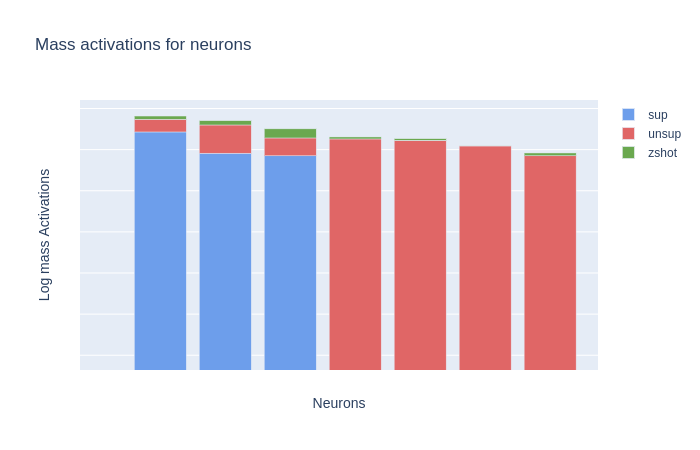

#### 비지도학습 모델(Frequency analysis)

In [ ]:
freq_analysis_plot(sup_data, unsup_data_epoch1, unsup_data_epoch49, data_dict)

##### Hellinger distance(zero-shot과 비지도학습)

In [ ]:
calculate_distance_flag = False

In [ ]:
if calculate_distance_flag == True:
    calculate_hellinger_distance(unsup_data, zero_shot_data, os.path.join("data","zshot_unsup_hellinger_distance.pickle"))

In [ ]:
hellinger_length_plot(os.path.join("data","zshot_unsup_hellinger_distance.pickle"),
                      os.path.join(data_dict["visualize"]["plot_directory"], "zshot_unsup_hellinger_length.pdf"))

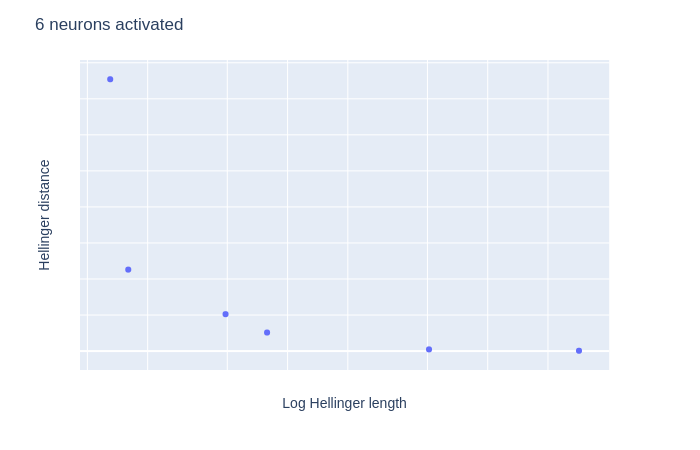

In [ ]:
length_shift_pos_plot(unsup_data, zero_shot_data, 'unsup', 'zshot', 
                        data_dict['visualize']['viz_colors']['unsup_color'], 
                        data_dict['visualize']['viz_colors']['zero_shot_color'], "unsup", "zshot", data_dict,
                        os.path.join(data_dict["visualize"]["plot_directory"], "zshot_unsup_length_shift_token_plot.pdf"))

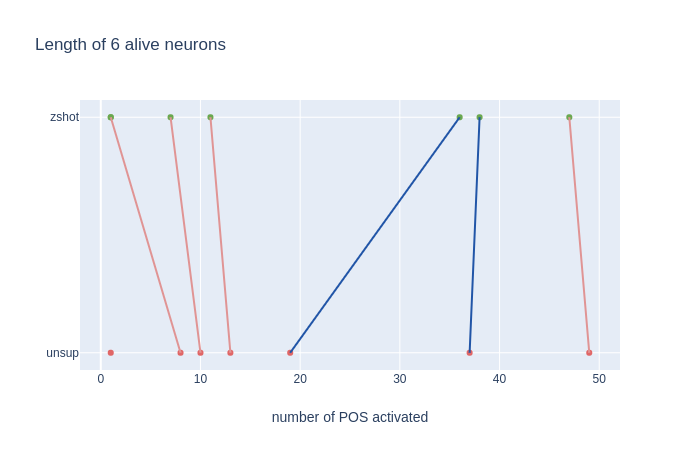

In [ ]:
plot_top_10_hellinger_neurons(os.path.join("data","zshot_unsup_hellinger_distance.pickle"), unsup_data,
                              zero_shot_data, data_dict['visualize']['viz_colors']['unsup_color'], 
                              data_dict['visualize']['viz_colors']['zero_shot_color'], "unsup", "zshot", 
                                  data_dict, "unsup_zshot_hellinger", n_tokens=5, process_data_flag=False)

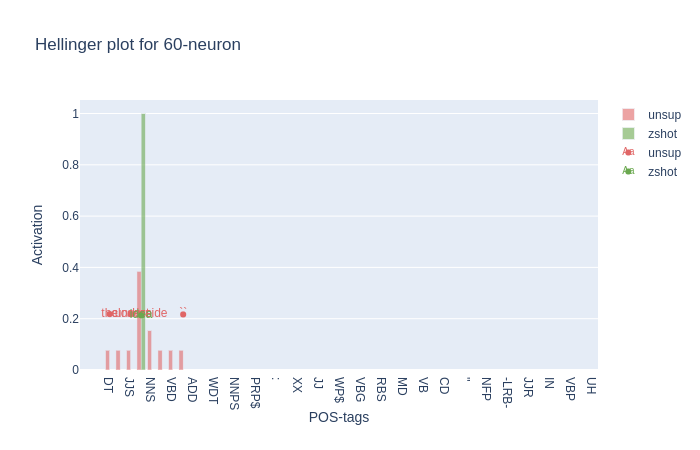
